In [1]:
import numpy as np
import scipy.spatial as spa
import scipy 
import prody
from pathlib import Path
import importlib
from typing import Union

import rdkit

import dgl
import torch

%matplotlib widget
from matplotlib import pyplot as plt

# define hard-coded filepaths

In [2]:
DEV_INDEX_PATH = '/home/ian/projects/mol_diffusion/ligdiff/data/PDBbind_processed/train_index_mini.txt'
DEV_DATA_DIR = '/home/ian/projects/mol_diffusion/ligdiff/data/PDBbind/refined-set'

DEV_DATA_DIR = Path(DEV_DATA_DIR)

# import code for processing pdbbind

In [13]:
try:
    importlib.reload(process_pdbbind)
except NameError:
    import data_processing.pdbbind_processing as process_pdbbind

parse_protein = process_pdbbind.parse_protein
parse_ligand = process_pdbbind.parse_ligand
get_pocket_atoms = process_pdbbind.get_pocket_atoms

# define dataset class for PDB

In [14]:
class PDBbind(dgl.data.DGLDataset):

    def __init__(self, name: str, index_fpath: str, 
        raw_data_dir: str,
        processed_data_dir: str,
        lig_box_padding: Union[int, float] = 10,
        pocket_cutoff: Union[int, float] = 4,
        receptor_k: int = 3):

        self.index_fpath: Path = Path(index_fpath)
        self.raw_data_dir: Path = Path(raw_data_dir)
        self.processed_data_dir: Path = Path(processed_data_dir)

        # hyperparameters for protein graph
        self.receptor_k: int = receptor_k
        self.lig_box_padding: Union[int, float] = lig_box_padding
        self.pocket_cutoff: Union[int, float] = pocket_cutoff



        super().__init__(name=name) # this has to happen last because this will call self.process()

    def __getitem__(self, i):
        pass

    def __len__(self):
        return 1

    def process(self):

        # TODO: implement logic that only goes makes the graph objects if they don't already exist

        # get pdb ids from index file
        with open(self.index_fpath, 'r') as f:
            pdb_ids = [line.strip() for line in f]

        # we will want to do this paralellized over PDBs
        # but for now, a simple for loop will do
        for pdb_id in pdb_ids:

            # get all atoms from pdb file
            pdb_atoms: prody.AtomGroup = parse_protein(pdb_id)

            # get rdkit molecule from ligand, as well as atom types and charges
            ligand, lig_atom_positions, lig_atom_features = parse_ligand(pdb_id)

            # get all protein atoms that form the binding pocket
            pocket_atom_positions, pocket_atom_features \
                 = get_pocket_atoms(pdb_atoms, lig_atom_positions, box_padding=self.lig_box_padding, pocket_cutoff=self.pocket_cutoff)
        


# method for finding binding pocket atoms

In [14]:
test_pdb_id = '1n4k'
protein_atoms = parse_protein(test_pdb_id, data_dir=DEV_DATA_DIR)
ligand, lig_atom_positions, lig_atom_features = parse_ligand(test_pdb_id, data_dir=DEV_DATA_DIR)

pocket_atom_positions, pocket_atom_features = get_pocket_atoms(protein_atoms, lig_atom_positions, box_padding=6, pocket_cutoff=4)

@> 4858 atoms and 1 coordinate set(s) were parsed in 0.09s.


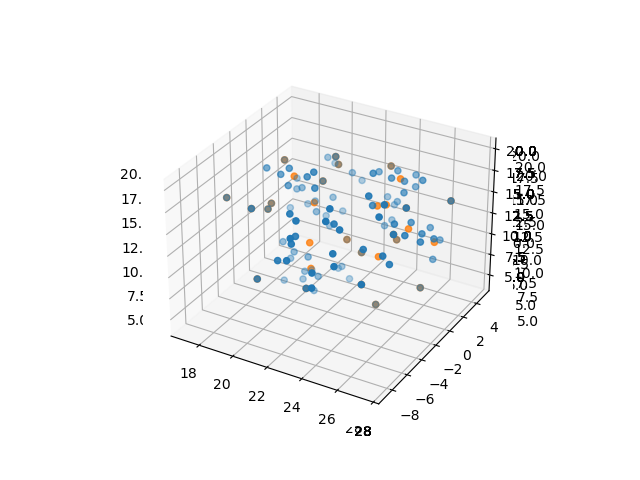

In [19]:
fig = plt.gcf()
ax = fig.add_subplot(projection='3d')

ax.scatter(pocket_atom_positions[:, 0], pocket_atom_positions[:, 1], pocket_atom_positions[:, 2])


cluster_assignments = scipy.cluster.hierarchy.fclusterdata(pocket_atom_positions, t=30, criterion='maxclust')

clustered_points = []
for cluster_idx in range(1, max(cluster_assignments)+1):
    cluster_mask = cluster_assignments == cluster_idx
    cluster_positions = pocket_atom_positions[cluster_mask]
    cluster_com = cluster_positions.mean(axis=0)

    # dist_to_com = np.linalg.norm(cluster_positions - cluster_com[None, :], axis=1)
    # avg_dist_to_com = dist_to_com.mean()
    # print(avg_dist_to_com)

    clustered_points.append(cluster_com)

clustered_points = np.stack(clustered_points, axis=0)

ax.scatter(clustered_points[:, 0], clustered_points[:, 1], clustered_points[:, 2], alpha=0.8)

plt.show()

In [18]:
max(cluster_assignments)

98

In [38]:
cluster_com

tensor([23.0120, -6.9730, 10.6190], dtype=torch.float64)

# build binding pocket graph

1. one-hot encode atom types
2. determine edges for KNN graph

In [17]:
def build_pocket_graph(atom_positions, atom_features, k=3, edge_algorithm='bruteforce'):
    # atom_positions is an array of shape (N, 3) where N is the number of atoms
    # atom_features is an array of shape (N, d) where N is the number of atoms and d is the size of the feature vector for each atom


    # construct KNN graph
    g = dgl.knn_graph(atom_positions, k=k, algorithm=edge_algorithm, dist='euclidean')
    return g

test_pdb_id = '1n4k'
protein_atoms = parse_protein(test_pdb_id, )
ligand, lig_atom_positions, lig_atom_types, lig_atom_charges = parse_ligand(test_pdb_id)
pocket_atom_positions, pocket_atom_types, pocket_atom_charges = get_pocket_atoms(protein_atoms, lig_atom_positions, cutoff=6)

g = build_pocket_graph(pocket_atom_positions, None)

TypeError: parse_protein() missing 1 required positional argument: 'data_dir'